In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from PIL import Image

csoupdata = pd.read_csv("./final_file.csv",sep=",",encoding='utf-8',\
                        usecols=[3,4,6,8,9])
                        
csoupdata.head()


,car_make,car_model,car_year,car_mileage,car_price
0,Toyota,Corolla-LE,2015,23036,13298
1,Jeep,Wrangler-Unlimted-Sahara,2012,73619,26995
2,Honda,Civic-LX,2014,27784,14097
3,Jeep,Grand-Cherokee-Limited,2014,36636,27899
4,Hyundai,Santa-Fe-Sport-24L,2013,48568,18981


In [2]:
#SELECTING single model
car_make_forPrediction = "Ford"
car_model_forPrediction = "Escape-SE"
car_year_forPrediction = 2014

#number of iterations to obtain samples
niter = 10000

# DataFrame with only data for the selected car_make
selected_data = csoupdata[(csoupdata.car_make == car_make_forPrediction) &\
                          (csoupdata.car_model == car_model_forPrediction) &\
                           (csoupdata.car_year == car_year_forPrediction) ]
                        #(csoupdata.car_mileage < 65000) ] # Removing and outlier from the data
selected_data.head()

,car_make,car_model,car_year,car_mileage,car_price
30,Ford,Escape-SE,2014,42694,16998
45,Ford,Escape-SE,2014,31246,15998
151,Ford,Escape-SE,2014,19581,18998
249,Ford,Escape-SE,2014,31482,18991
357,Ford,Escape-SE,2014,94967,12995


In [3]:
selected_data.describe()

,car_year,car_mileage,car_price
count,82.0,82.000000,82.000000
mean,2014.0,33120.329268,17121.329268
std,0.0,16728.795753,2159.915951
min,2014.0,3886.000000,9991.000000
25%,2014.0,23489.000000,15982.750000
50%,2014.0,30315.000000,16998.000000
75%,2014.0,38173.000000,17998.000000
max,2014.0,103445.000000,22997.000000


#Plotting simple linear regression

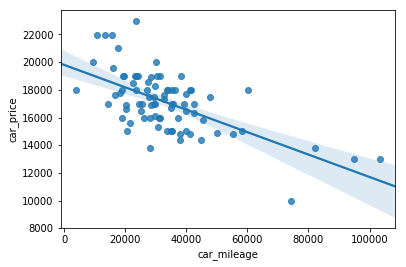

In [4]:

sns.regplot(x='car_mileage',y='car_price',data=selected_data)

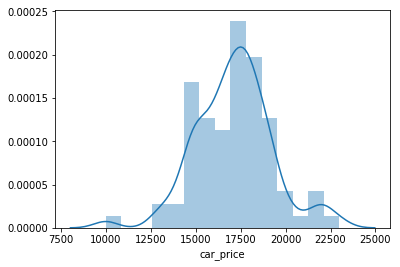

In [5]:
sns.distplot(selected_data.car_price)


#Model Creation and Plotting
    Y ∼ N(μ,σ2)
    μ = α + βX #price_est

    Y ==> Price RV #price_like
    X ==> Mileage 

    α ∼ Normal Dist #intercept_year_overall
    β ∼ Normal Dist #miles_year_overal
    σ ~ Uniform Dist #model_error


In [6]:

from pymc3 import *
num_years = len(selected_data.car_price)

with pm.Model() as price_ymm:
    
        # Stochastic Random Variables with Random Distribution
        intercept_mu = selected_data.car_price.mean()
        intercept_year_mean = pm.Normal('intercept_year_mean', mu=intercept_mu, sd=10000.)
        intercept_year_sd = pm.Normal('intercept_year_sd',mu=intercept_mu, sd=10000.)
        intercept_year_overall = pm.Normal('intercept_year_overall',
                                           mu=intercept_year_mean, sd=intercept_year_sd,shape=num_years)

        miles_year_mean = pm.Normal('miles_year_mean', mu=0, sd=10000.)
        miles_year_sd = pm.Gamma('miles_year_sd', mu=0.0001, sd=10000.)
        #miles distribuitions
        miles_year_overall = pm.Normal('miles_year_overall',mu=miles_year_mean,
                                        sd=miles_year_sd,shape=num_years)
    

        price_est = intercept_year_overall + miles_year_overall * selected_data.car_mileage
        
        # model error
        model_error = pm.Uniform('model_error', lower=0, upper=100000)

        # calculate likelihood
        price_like = pm.Normal('price_like', mu=price_est, sd=model_error, observed=selected_data.car_price)

        # Sampling method to generate posterior sample
        step = pm.Metropolis()
        trace = pm.sample(niter,step=step)

100%|██████████| 10500/10500 [00:31<00:00, 338.42it/s]


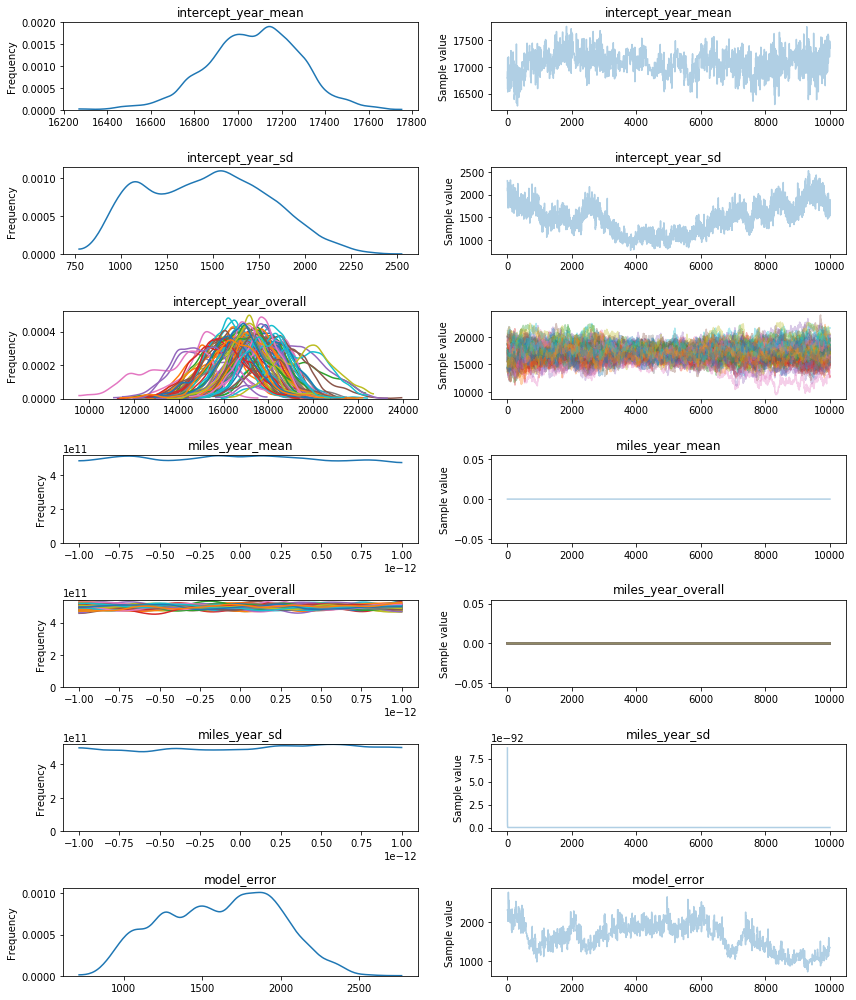

In [7]:
plt.figure(figsize=(7, 7))
traceplot(trace)
plt.tight_layout();


In [8]:
pm.summary(trace)



intercept_year_mean:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  17067.477        211.260          13.643           [16655.593, 17490.168]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  16634.213      16932.166      17078.177      17212.798      17477.011


intercept_year_sd:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1467.338         328.060          30.419           [888.366, 2035.049]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  934.296        1192.522       1474.768       1708.700       2112.385


intercept_year_overall:

  Mean             SD             

100%|██████████| 10/10 [00:00<00:00, 65.54it/s]


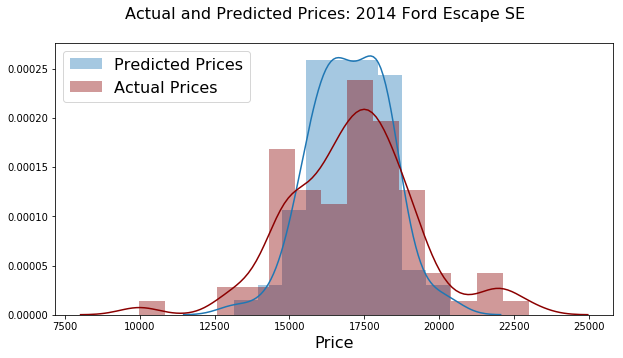

In [9]:
ppc = pm.sample_ppc(trace, model=price_ymm,samples=10)
pred_prices = np.mean(ppc['price_like'],axis=0)

fig,ax = plt.subplots(figsize=(10,5),sharex=True)

fig.suptitle('Actual and Predicted Prices: 2014 Ford Escape SE',fontsize=16)
# predicted
sns.distplot(pred_prices,label='Predicted Prices')

# actual
sns.distplot(selected_data.car_price,color='darkred',label='Actual Prices')
plt.xlabel('Price',fontsize=16)
plt.legend(loc='upper left',fontsize=16)

plt.show()


In [ ]:
Reference: https://github.com/clrife/CarPriceAnalysis/blob/master/CarPriceAnalysis_Technical.ipynb